In [ ]:
pip install pyspark

In [ ]:
# Step 2: Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

# Step 3: Initialize Spark session
spark = SparkSession.builder.appName("EarthquakeAnalysis").getOrCreate()

# Step 4: Load dataset from local path in Colab
df = spark.read.csv("/content/dataset.csv", header=True, inferSchema=True)

# Step 5: Define numeric and categorical columns
numeric_cols = ['latitude', 'longitude', 'depth', 'tsunami', 'significance']
categorical_columns = ['data_type', 'state', 'status']

# Step 6: Cast numeric columns and fill nulls with medians
for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

def fill_with_median(df, columns):
    medians = df.select([
        F.expr(f'percentile_approx({c}, 0.5)').alias(c) for c in columns
    ]).first().asDict()
    return df.na.fill(medians)

df = fill_with_median(df, numeric_cols)

# Step 7: Drop unneeded columns
df = df.drop('time', 'date', 'place')

# Step 8: Encode categorical variables
stages = []
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_vec"])
    stages += [indexer, encoder]

# Step 9: Rename and cast label column
df = df.withColumnRenamed("magnitudo", "label").withColumn("label", col("label").cast(DoubleType()))

# Step 10: Vector assembler for features
assembler_inputs = [c + "_vec" for c in categorical_columns] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages.append(assembler)

# Step 11: Build pipeline and transform
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# Step 12: Final dataset
final_df = df_transformed.select("features", "label")
final_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(526,[0,11,519,52...|  2.5|
|(526,[0,12,519,52...| 1.41|
|(526,[0,9,519,521...| 1.11|
|(526,[0,9,519,521...| 0.98|
|(526,[0,10,519,52...| 2.95|
+--------------------+-----+
only showing top 5 rows



#SVM

In [ ]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F

# Start Spark
spark = SparkSession.builder.appName("EarthquakeSVMStratified").getOrCreate()

# Load dataset
df = spark.read.csv("/content/dataset.csv", header=True, inferSchema=True)

# Define numeric columns and clean
numeric_cols = ['latitude', 'longitude', 'depth', 'magnitudo']
df = df.dropna(subset=numeric_cols)

def fill_with_median(df, columns):
    medians = df.select([F.expr(f'percentile_approx({c}, 0.5)').alias(c) for c in columns]).first().asDict()
    return df.na.fill(medians)

df = fill_with_median(df, numeric_cols)
df = df.drop(*[c for c in ['time', 'date', 'place'] if c in df.columns])

# Create label
df = df.withColumn("label", when(col("magnitudo") >= 7.5, 1).otherwise(0).cast(DoubleType()))

# Categorical columns
categorical_cols = [c for c in ['state', 'data_type', 'status'] if c in df.columns]
stages = []

for cat in categorical_cols:
    indexer = StringIndexer(inputCol=cat, outputCol=cat + "_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[cat + "_idx"], outputCols=[cat + "_vec"])
    stages += [indexer, encoder]

# Assemble features
assembler_inputs = [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages.append(assembler)

# Build pipeline
pipeline = Pipeline(stages=stages)

# === Manual Stratified Splitting ===
df_1 = df.filter(col("label") == 1)
df_0 = df.filter(col("label") == 0).sample(False, 0.02, seed=42)  # Sample 2% of class 0

# Combine and split each class
train_1, test_1 = df_1.randomSplit([0.8, 0.2], seed=42)
train_0, test_0 = df_0.randomSplit([0.8, 0.2], seed=42)

train_df = train_1.union(train_0)
test_df = test_1.union(test_0)

# Apply transformation
pipeline_model = pipeline.fit(train_df.union(test_df))
train_transformed = pipeline_model.transform(train_df).select("features", "label")
test_transformed = pipeline_model.transform(test_df).select("features", "label")

# Define SVM model and hyperparameter grid
svm = LinearSVC(featuresCol="features", labelCol="label")
param_grid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1]) \
    .addGrid(svm.maxIter, [10, 50, 100]) \
    .build()

# Cross-validator
cross_validator_svm = CrossValidator(
    estimator=svm,
    estimatorParamMaps=param_grid_svm,
    evaluator=BinaryClassificationEvaluator(labelCol="label"),
    numFolds=5
)

# Train model
cv_model_svm = cross_validator_svm.fit(train_transformed)

# Predict
predictions_svm = cv_model_svm.bestModel.transform(test_transformed)

# Evaluate
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label")
accuracy = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "accuracy"})
f1_score = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "f1"})
precision = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "weightedRecall"})

print("Stratified SVM Results:")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

# Confusion matrix
print("Confusion Matrix:")
predictions_svm.groupBy("label").pivot("prediction", [0.0, 1.0]).count().na.fill(0).show()

# Best model parameters
best_model_svm = cv_model_svm.bestModel
print("Best Model Parameters:")
print(f" - RegParam: {best_model_svm._java_obj.getRegParam()}")
print(f" - MaxIter : {best_model_svm._java_obj.getMaxIter()}")


Stratified SVM Results:
Accuracy : 0.9963
F1 Score : 0.9945
Precision: 0.9926
Recall   : 0.9963
Confusion Matrix:
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0|810|  0|
|  1.0|  3|  0|
+-----+---+---+

Best Model Parameters:
 - RegParam: 0.01
 - MaxIter : 100


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

# Start Spark session
spark = SparkSession.builder.appName("EarthquakeBinaryClassification").getOrCreate()

# Load dataset
df_main = spark.read.csv("/content/dataset.csv", header=True, inferSchema=True)

# Clean numeric columns
numeric_cols = ['latitude', 'longitude', 'depth', 'magnitudo']
df_main = df_main.dropna(subset=numeric_cols)

# Fill numeric nulls with median
def fill_with_median(df, cols):
    stats = df.select([F.expr(f'percentile_approx({c}, 0.5)').alias(c) for c in cols]).first().asDict()
    return df.na.fill(stats)

df_main = fill_with_median(df_main, numeric_cols)

# Drop irrelevant columns if present
df_main = df_main.drop(*[c for c in ['time', 'date', 'place'] if c in df_main.columns])

# Handle categorical columns
categorical_cols = [c for c in ['state', 'status', 'data_type'] if c in df_main.columns]
stages = []

for cat in categorical_cols:
    indexer = StringIndexer(inputCol=cat, outputCol=cat + "_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[cat + "_idx"], outputCols=[cat + "_vec"])
    stages += [indexer, encoder]

# Assemble features
assembler_inputs = [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages.append(assembler)

# Pipeline and transformation
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df_main)
df_main_transformed = pipeline_model.transform(df_main)

# Create binary label
threshold = 4.5
df_main_transformed = df_main_transformed.withColumn(
    "binaryLabel", when(col("magnitudo") > threshold, 1).otherwise(0).cast(DoubleType())
)

# Split data
train_main_data, test_main_data = df_main_transformed.select("features", col("binaryLabel").alias("label")) \
    .randomSplit([0.7, 0.3], seed=42)


In [ ]:
from pyspark.ml.classification import LinearSVC

# Create the SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model
svm_model = svm.fit(train_main_data)

# Make predictions
predictions = svm_model.transform(test_main_data)



In [ ]:
# Step 1: Stratify the evaluation data
df_main_1 = df_main.filter(col("magnitudo") > 4.5)   # label 1
df_main_0 = df_main.filter(col("magnitudo") <= 4.5)  # label 0

# Sample 2% of class 0 to match class 1
df_main_0_sampled = df_main_0.sample(False, 0.02, seed=42)

# Combine for balanced test set
df_eval_stratified = df_main_1.union(df_main_0_sampled)

# Step 2: Transform using the SAME pipeline model used for training
df_eval_transformed = pipeline_model.transform(df_eval_stratified)

# Step 3: Add binary label column
df_eval_transformed = df_eval_transformed.withColumn(
    "label", when(col("magnitudo") > 4.5, 1).otherwise(0).cast(DoubleType())
)

# Step 4: Predict using trained model
predictions = svm_model.transform(df_eval_transformed.select("features", "label"))

# Step 5: Evaluate
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print metrics
print("Stratified Evaluation Results:")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

# Optional: Confusion matrix
print("Confusion Matrix:")
predictions.groupBy("label").pivot("prediction", [0.0, 1.0]).count().na.fill(0).show()


Stratified Evaluation Results:
Accuracy : 0.9888
F1 Score : 0.9889
Precision: 0.9891
Recall   : 0.9888
Confusion Matrix:
+-----+----+-----+
|label| 0.0|  1.0|
+-----+----+-----+
|  0.0|4041|   24|
|  1.0| 157|11943|
+-----+----+-----+



# logistic regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# === Step 1: Re-transform training data using the SAME pipeline_model ===
df_train_stratified = train_df  # Use your existing stratified train_df
df_train_transformed = pipeline_model.transform(df_train_stratified)

# Ensure label column is present
df_train_transformed = df_train_transformed.withColumn(
    "label", when(col("magnitudo") > 4.5, 1).otherwise(0).cast(DoubleType())
)

# Select features and label for training
train_transformed_lr = df_train_transformed.select("features", "label")

# === Step 2: Define Logistic Regression and CrossValidator ===
lr = LogisticRegression(featuresCol="features", labelCol="label")

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

binary_evaluator = BinaryClassificationEvaluator(labelCol="label")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label")

cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=binary_evaluator,
    numFolds=5
)

# === Step 3: Train Logistic Regression model ===
cv_model = cross_validator.fit(train_transformed_lr)

# === Step 4: Predict on stratified evaluation data (already transformed with SAME pipeline) ===
predictions = cv_model.bestModel.transform(df_eval_transformed.select("features", "label"))

# === Step 5: Evaluate ===
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

print("Logistic Regression Evaluation (Stratified):")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

# Confusion matrix
print("Confusion Matrix:")
predictions.groupBy("label").pivot("prediction", [0.0, 1.0]).count().na.fill(0).show()

# Best model parameters
best_model = cv_model.bestModel
print("Best Model Parameters:")
print(f" - RegParam        : {best_model._java_obj.getRegParam()}")
print(f" - MaxIter         : {best_model._java_obj.getMaxIter()}")
print(f" - ElasticNetParam : {best_model._java_obj.getElasticNetParam()}")


Logistic Regression Evaluation (Stratified):
Accuracy : 0.8461
F1 Score : 0.8552
Precision: 0.9027
Recall   : 0.8461
Confusion Matrix:
+-----+----+----+
|label| 0.0| 1.0|
+-----+----+----+
|  0.0|4038|  27|
|  1.0|2461|9639|
+-----+----+----+

Best Model Parameters:
 - RegParam        : 0.01
 - MaxIter         : 50
 - ElasticNetParam : 0.5


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Create the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Train the model
lr_model = lr.fit(train_main_data)

# Make predictions
predictions = lr_model.transform(test_main_data)


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# === Step 1: Recompute predictions using stratified and re-transformed evaluation data ===
predictions = cv_model.bestModel.transform(df_eval_transformed.select("features", "label"))

# === Step 2: Evaluate ===
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# === Step 3: Display ===
print("Logistic Regression Evaluation (Stratified):")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

# Optional: confusion matrix
print("Confusion Matrix:")
predictions.groupBy("label").pivot("prediction", [0.0, 1.0]).count().na.fill(0).show()


Logistic Regression Evaluation (Stratified):
Accuracy : 0.8461
F1 Score : 0.8552
Precision: 0.9027
Recall   : 0.8461
Confusion Matrix:
+-----+----+----+
|label| 0.0| 1.0|
+-----+----+----+
|  0.0|4038|  27|
|  1.0|2461|9639|
+-----+----+----+



#random forest


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# === Step 1: Re-transform your stratified balanced dataset ===
# (Assuming pipeline_model already exists and is fitted on full df)

# Transform train stratified data
df_train_transformed = pipeline_model.transform(train_df)

# Create label again (threshold 4.5 for binary classification)
df_train_transformed = df_train_transformed.withColumn(
    "label", when(col("magnitudo") > 4.5, 1).otherwise(0).cast(DoubleType())
)

# Final feature-label train set
train_rf = df_train_transformed.select("features", "label")

# Similarly transform test stratified data
df_test_transformed = pipeline_model.transform(test_df)
df_test_transformed = df_test_transformed.withColumn(
    "label", when(col("magnitudo") > 4.5, 1).otherwise(0).cast(DoubleType())
)

test_rf = df_test_transformed.select("features", "label")

# === Step 2: Define Random Forest Classifier ===
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# === Step 3: Define ParamGrid for Hyperparameter Tuning ===
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

# === Step 4: CrossValidator Setup ===
binary_evaluator = BinaryClassificationEvaluator(labelCol="label")

cross_validator_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid_rf,
    evaluator=binary_evaluator,
    numFolds=5,
    seed=42
)

# === Step 5: Train Random Forest Model ===
cv_model_rf = cross_validator_rf.fit(train_rf)

# === Step 6: Make Predictions ===
predictions_rf = cv_model_rf.bestModel.transform(test_rf)

# === Step 7: Evaluate ===
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label")

accuracy_rf = multiclass_evaluator.setMetricName("accuracy").evaluate(predictions_rf)
f1_score_rf = multiclass_evaluator.setMetricName("f1").evaluate(predictions_rf)
precision_rf = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(predictions_rf)
recall_rf = multiclass_evaluator.setMetricName("weightedRecall").evaluate(predictions_rf)

print("✅ Random Forest Evaluation (Stratified Test Set):")
print(f"Accuracy : {accuracy_rf:.4f}")
print(f"F1 Score : {f1_score_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall   : {recall_rf:.4f}")

# === Step 8: Confusion Matrix ===
print("Confusion Matrix:")
predictions_rf.groupBy("label").pivot("prediction", [0.0, 1.0]).count().na.fill(0).show()

# === Step 9: Best Model Hyperparameters ===
best_model_rf = cv_model_rf.bestModel
print("Best Model Parameters for Random Forest:")
print(f" - MaxDepth : {best_model_rf._java_obj.getMaxDepth()}")
print(f" - NumTrees : {best_model_rf._java_obj.getNumTrees()}")


✅ Random Forest Evaluation (Stratified Test Set):
Accuracy : 0.9643
F1 Score : 0.9617
Precision: 0.9622
Recall   : 0.9643
Confusion Matrix:
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0|744|  6|
|  1.0| 23| 40|
+-----+---+---+

Best Model Parameters for Random Forest:
 - MaxDepth : 10
 - NumTrees : 50


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)  # You can adjust numTrees if needed

# Train the model
rf_model = rf.fit(train_main_data)

# Make predictions
predictions = rf_model.transform(test_main_data)


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluators for computing the metrics
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print the results
print(f"✅ Random Forest Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")


✅ Random Forest Evaluation Metrics:
Accuracy : 0.9433
F1 Score : 0.9170
Precision: 0.9274
Recall   : 0.9433


In [ ]:
# Print feature importances
print("Feature Importances:", rf_model.featureImportances)


Feature Importances: (525,[0,2,8,12,13,14,15,16,25,27,34,35,37,39,41,42,54,60,61,68,70,75,78,90,92,101,103,110,138,146,151,243,521,522,523,524],[0.047495644840020584,0.03066092828943711,0.029422578904014195,0.005762688293932032,0.044435033427400863,0.03539786678740646,0.038201557955288894,0.06734247013366441,0.013979496324915488,0.022438421502865992,0.0031355767223131465,0.006393262872567994,0.011607950968032082,0.0017072155863415788,0.0010957762408624683,0.016823058348769827,0.001520336536236012,0.008468151698143337,0.007277951629828666,0.015739192626416702,0.0018492421237881226,0.0016069629762651906,1.3961404651024915e-05,0.0009479546167246583,0.0007948265007171843,0.007384645665583334,0.0013702288242926452,0.001104151177082325,0.0003010451918446957,0.0008380667144340529,0.0003337907850856494,0.00010675588385375501,0.22782391781971967,0.19971371850054476,0.10766029824840798,0.039245273878547156])


In [ ]:
# Print feature importances
importances = rf_model.featureImportances
print("Feature Importances:", importances)
# List of input columns to the VectorAssembler
input_columns = assembler_inputs  # This list should have been defined when you set up your VectorAssembler

# Creating a dictionary to map feature vector indices back to feature names
feature_index = {i: col for i, col in enumerate(input_columns)}

# Optionally, convert feature importances to a more readable format
# Assuming you have a list of feature names corresponding to indices in the features vector
feature_names = [feature_index[i] for i in range(len(feature_index))]  # Reuse feature_index from previous examples
feature_importance_dict = dict(zip(feature_names, importances))
print("Readable Feature Importances:", feature_importance_dict)


Feature Importances: (525,[0,2,8,12,13,14,15,16,25,27,34,35,37,39,41,42,54,60,61,68,70,75,78,90,92,101,103,110,138,146,151,243,521,522,523,524],[0.047495644840020584,0.03066092828943711,0.029422578904014195,0.005762688293932032,0.044435033427400863,0.03539786678740646,0.038201557955288894,0.06734247013366441,0.013979496324915488,0.022438421502865992,0.0031355767223131465,0.006393262872567994,0.011607950968032082,0.0017072155863415788,0.0010957762408624683,0.016823058348769827,0.001520336536236012,0.008468151698143337,0.007277951629828666,0.015739192626416702,0.0018492421237881226,0.0016069629762651906,1.3961404651024915e-05,0.0009479546167246583,0.0007948265007171843,0.007384645665583334,0.0013702288242926452,0.001104151177082325,0.0003010451918446957,0.0008380667144340529,0.0003337907850856494,0.00010675588385375501,0.22782391781971967,0.19971371850054476,0.10766029824840798,0.039245273878547156])
Readable Feature Importances: {'state_vec': np.float64(0.047495644840020584), 'status_ve

## PLOTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from matplotlib.ticker import MultipleLocator
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
main = pd.read_csv("/content/dataset.csv")

In [ ]:
main.head()

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
0,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,0,96,earthquake,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,"14 km S of Volcano, Hawaii",reviewed,0,31,earthquake,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,"7 km W of Cobb, California",reviewed,0,19,earthquake,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,"11 km E of Mammoth Lakes, California",reviewed,0,15,earthquake,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,"16km N of Fillmore, CA",reviewed,0,134,earthquake,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


<Axes: xlabel='data_type'>

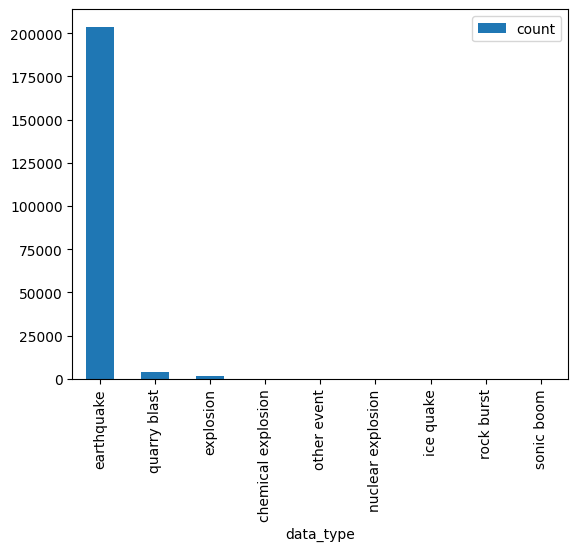

In [ ]:
# main['type'].value_counts().plot(kind='bar')
df.select('data_type').groupBy('data_type').count().orderBy('count', ascending=False).toPandas().set_index('data_type').plot(kind='bar')


<Axes: xlabel='place'>

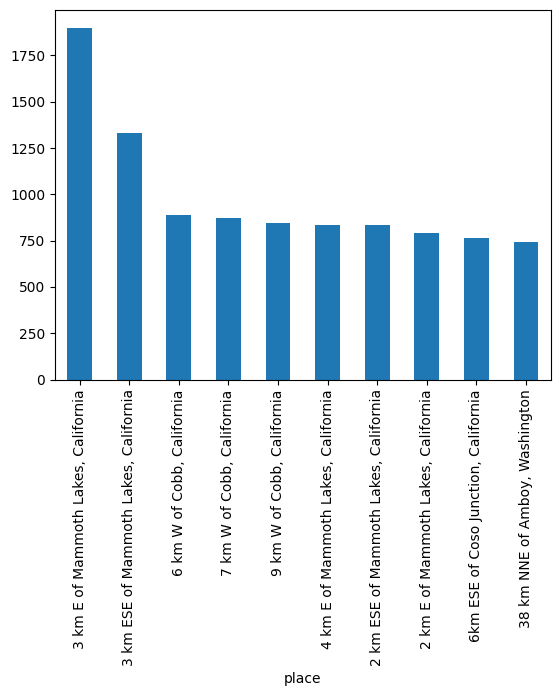

In [ ]:
place_count=main['place'].value_counts()
place_count.head(10).plot(kind='bar')

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


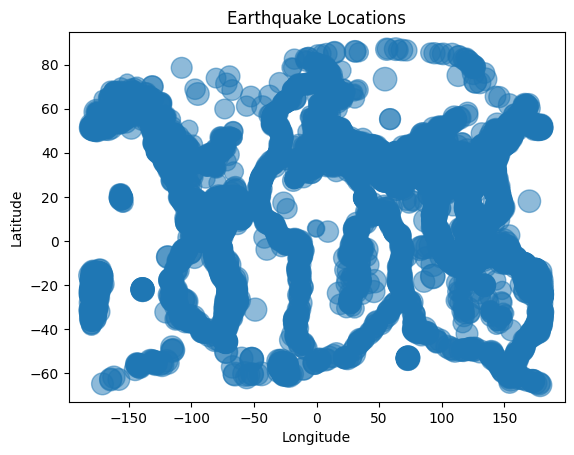

In [ ]:
import matplotlib.pyplot as plt

# Extract the latitude, longitude, and magnitude columns
latitude = main['latitude']
longitude = main['longitude']
magnitude = main['magnitudo']

# Create the scatter plot
plt.scatter(longitude, latitude, s=magnitude*50, alpha=0.5)

# Add a title and labels to the axes
plt.title('Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

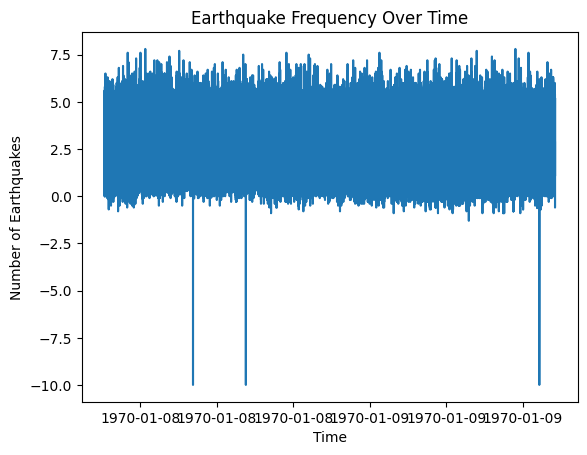

In [ ]:
import matplotlib.dates as mdates

# Extract the time column
time = main['time']

# Convert the dates to numerical values
time_num = mdates.date2num(time)

# Create the line plot
plt.plot(time_num, magnitude)

# Add a title and labels to the axes
plt.title('Earthquake Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Earthquakes')

# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Show the plot
plt.show()

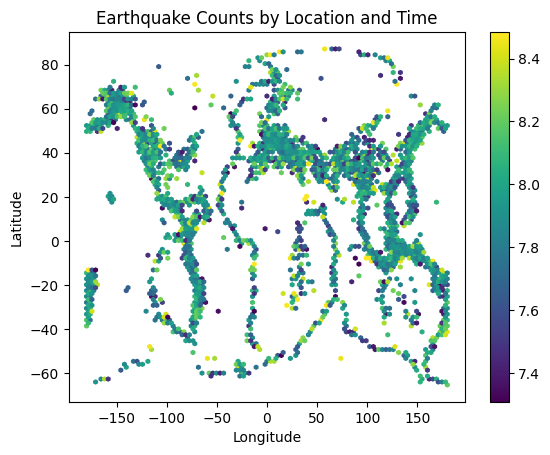

In [ ]:
import matplotlib.dates as mdates

# Extract the latitude, longitude, and time columns
latitude = main['latitude']
longitude = main['longitude']
time = main['time']

# Convert the dates to numerical values
time_num = mdates.date2num(time)

# Create the heat map
plt.hexbin(longitude, latitude, C=time_num, cmap='viridis')

# Add a colorbar
plt.colorbar()

# Add a title and labels to the axes
plt.title('Earthquake Counts by Location and Time')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
state_dict = {'Alabama': 'AL',
'Alaska': 'AK',
'Arizona': 'AZ',
'Arkansas': 'AR',
'California': 'CA',
'Colorado': 'CO',
'Connecticut': 'CT',
'Delaware': 'DE',
'Florida': 'FL',
'Georgia': 'GA',
'Hawaii': 'HI',
'Idaho': 'ID',
'Illinois': 'IL',
'Indiana': 'IN',
'Iowa': 'IA',
'Kansas': 'KS',
'Kentucky': 'KY',
'Louisiana': 'LA',
'Maine': 'ME',
'Maryland': 'MD',
'Massachusetts': 'MA',
'Michigan': 'MI',
'Minnesota': 'MN',
'Mississippi': 'MS',
'Missouri': 'MO',
'Montana': 'MT',
'Nebraska': 'NE',
'Nevada': 'NV',
'New Hampshire': 'NH',
'New Jersey': 'NJ',
'New Mexico': 'NM',
'New York': 'NY',
'North Carolina': 'NC',
'North Dakota': 'ND',
'Ohio': 'OH',
'Oklahoma': 'OK',
'Oregon': 'OR',
'Pennsylvania': 'PA',
'Rhode Island': 'RI',
'South Carolina': 'SC',
'South Dakota': 'SD',
'Tennessee': 'TN',
'Texas': 'TX',
'Utah': 'UT',
'Vermont': 'VT',
'Virginia': 'VA',
'Washington': 'WA',
'West Virginia': 'WV',
'Wisconsin': 'WI',
'Wyoming': 'WY', 'Virgin Islands': 'VIRG', 'Puerto Rico':'PR'}

In [ ]:
valid_indices = []
for index, row in main.iterrows():
    for x in state_dict:
        if row['place'].endswith(x):
            valid_indices.append(index)
            break
        elif row['place'].endswith(state_dict[x]):
            valid_indices.append(index)
            break

In [ ]:
print(np.shape(main))
print(np.shape(valid_indices))

(209732, 12)
(171354,)


In [ ]:
main[~main.index.isin(valid_indices)]

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
19,631162061250,"35 km SSW of Mandráki, Greece",reviewed,0,168,earthquake,3.3,Greece,26.969,36.323,144.8,1990-01-01 02:47:41.250000+00:00
21,631164358270,"2 km SSW of Monterosso Grana, Italy",reviewed,0,39,earthquake,1.6,Italy,7.312,44.384,10.0,1990-01-01 03:25:58.270000+00:00
48,631175644000,"17 km SW of Shëngjin, Albania",reviewed,0,168,earthquake,3.3,Albania,19.431,41.714,10.0,1990-01-01 06:34:04+00:00
55,631180175570,Fiji region,reviewed,0,449,earthquake,5.4,Fiji region,-179.361,-21.772,599.5,1990-01-01 07:49:35.570000+00:00
66,631184592880,"3 km NE of Hitachi-Naka, Japan",reviewed,0,354,earthquake,4.8,Japan,140.568,36.417,67.9,1990-01-01 09:03:12.880000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
209715,733108249260,"133 km ESE of Tobelo, Indonesia",reviewed,0,416,earthquake,5.2,Indonesia,129.050,1.119,33.0,1993-03-26 01:10:49.260000+00:00
209718,733108985440,"24 km NE of Leposaviq, Kosovo",reviewed,0,112,earthquake,2.7,Kosovo,21.044,43.238,10.0,1993-03-26 01:23:05.440000+00:00
209721,733109884290,"232 km N of Metinaro, Timor Leste",reviewed,0,385,earthquake,5.0,Timor Leste,125.549,-6.441,554.8,1993-03-26 01:38:04.290000+00:00
209726,733114160120,"19 km ENE of K?rka?aç, Turkey",reviewed,0,148,earthquake,3.1,Turkey,27.882,39.176,10.0,1993-03-26 02:49:20.120000+00:00


In [ ]:
US_df = main[main.index.isin(valid_indices)]
states = []
for row in US_df['place']:
    for x in state_dict:
        if row.endswith(x):
            states.append(x)
            break
        elif row.endswith(state_dict[x]):
            states.append(x)
            break
US_df['state'] = states
US_df

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
0,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,0,96,earthquake,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,"14 km S of Volcano, Hawaii",reviewed,0,31,earthquake,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,"7 km W of Cobb, California",reviewed,0,19,earthquake,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,"11 km E of Mammoth Lakes, California",reviewed,0,15,earthquake,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,"16km N of Fillmore, CA",reviewed,0,134,earthquake,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
209725,733113222300,"7km N of Yucca Valley, California",reviewed,0,21,earthquake,1.16,California,-116.442000,34.177000,3.357,1993-03-26 02:33:42.300000+00:00
209728,733114748030,"3 km SE of Scotts Mills, Oregon",reviewed,0,39,earthquake,1.60,Oregon,-122.633167,45.025000,20.518,1993-03-26 02:59:08.030000+00:00
209729,733115065440,"20km N of Yucca Valley, California",reviewed,0,27,earthquake,1.33,California,-116.441000,34.294000,2.847,1993-03-26 03:04:25.440000+00:00
209730,733116335050,"13 km NNW of Orangeville, Utah",reviewed,0,89,earthquake,2.40,Utah,-111.133500,39.333333,5.980,1993-03-26 03:25:35.050000+00:00


In [ ]:
US_df = US_df.drop(['gap', 'id', 'locationSource', 'magSource', 'nst', 'dmin', 'net', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst', 'updated', 'status'], axis=1)
US_df

,time,latitude,longitude,depth,mag,magType,place,type,state
0,2022-03-04T21:28:02.440Z,38.759666,-122.719666,1.61,1.24,md,"3km SW of Anderson Springs, CA",earthquake,California
1,2022-03-04T21:27:28.190Z,38.833832,-122.815498,1.82,1.13,md,"8km NW of The Geysers, CA",earthquake,California
2,2022-03-04T21:25:05.130Z,35.596668,-120.271332,11.57,2.31,md,"11km SE of Shandon, CA",earthquake,California
3,2022-03-04T21:20:43.590Z,35.929167,-117.660833,3.25,0.88,ml,"22km E of Little Lake, CA",earthquake,California
4,2022-03-04T21:19:08.215Z,62.360200,-149.634500,9.80,1.40,ml,"24 km NNE of Susitna North, Alaska",earthquake,Alaska
...,...,...,...,...,...,...,...,...,...
75804,2022-12-12T21:08:56.860Z,19.283300,-64.906100,24.00,3.55,md,"104 km N of Charlotte Amalie, U.S. Virgin Islands",earthquake,Virgin Islands
75805,2022-12-12T08:04:39.081Z,38.248400,-118.357200,10.00,0.60,ml,"26 km SW of Mina, Nevada",earthquake,Nevada
75806,2022-12-12T08:00:43.492Z,36.789300,-116.224700,5.10,0.10,ml,"49 km ESE of Beatty, Nevada",earthquake,Nevada
75807,2022-12-12T22:36:07.230Z,33.032667,-116.396500,9.19,0.93,ml,"20km ESE of Julian, CA",earthquake,California


In [ ]:
severity = []
for x in US_df['magnitudo']:
    if x <= 3.9:
        severity.append('not felt')
    elif x <= 4.9:
        severity.append('small')
    elif x <= 5.9:
        severity.append('moderate')
    else:
        severity.append('strong')
US_df['severity'] = severity

In [ ]:
depth_category = []
for x in US_df['depth']:
    if x <= 70:
        depth_category.append('shallow')
    elif x <= 300:
        depth_category.append('intermediate')
    else:
        depth_category.append('deep')
US_df['depth category'] = depth_category

In [ ]:
US_df.to_csv(r'export_dataframe.csv')

In [ ]:
US_df.isnull().sum()

,0
time,0
place,0
status,0
tsunami,0
significance,0
data_type,0
magnitudo,0
state,0
longitude,0
latitude,0


In [ ]:
null_mag = US_df[US_df['magnitudo'].isnull()].index
US_df.drop(null_mag, inplace = True)
US_df.isnull().sum()

,0
time,0
place,0
status,0
tsunami,0
significance,0
data_type,0
magnitudo,0
state,0
longitude,0
latitude,0


In [ ]:
print(US_df[(US_df['latitude'] < -90) | (US_df['latitude'] > 90)])
print(US_df[(US_df['longitude'] < -180) | (US_df['longitude'] > 180)])

Empty DataFrame
Columns: [time, place, status, tsunami, significance, data_type, magnitudo, state, longitude, latitude, depth, date, severity, depth category]
Index: []
Empty DataFrame
Columns: [time, place, status, tsunami, significance, data_type, magnitudo, state, longitude, latitude, depth, date, severity, depth category]
Index: []


In [ ]:
print('The deepest earthquake reading was at ' + str(US_df['depth'].max())+'km')
print('The shallowest earthquake reading was at ' + str(US_df['depth'].min())+'km')

The deepest earthquake reading was at 308.5km
The shallowest earthquake reading was at -3.672km


In [ ]:
print('Original value counts for data_type:')
print(US_df['data_type'].value_counts())

US_df['data_type'].replace(['Ml', 'mww', 'Mb'], ['ml', 'mw', 'mb'], inplace=True)

print('Corrected value counts for data_type:')
print(US_df['data_type'].value_counts())


Original value counts for data_type:
data_type
earthquake            165654
quarry blast            4109
explosion               1453
chemical explosion        50
other event               39
nuclear explosion         20
ice quake                 19
rock burst                 9
sonic boom                 1
Name: count, dtype: int64
Corrected value counts for data_type:
data_type
earthquake            165654
quarry blast            4109
explosion               1453
chemical explosion        50
other event               39
nuclear explosion         20
ice quake                 19
rock burst                 9
sonic boom                 1
Name: count, dtype: int64


<ipython-input-55-e50c77a6e950>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  US_df['data_type'].replace(['Ml', 'mww', 'Mb'], ['ml', 'mw', 'mb'], inplace=True)


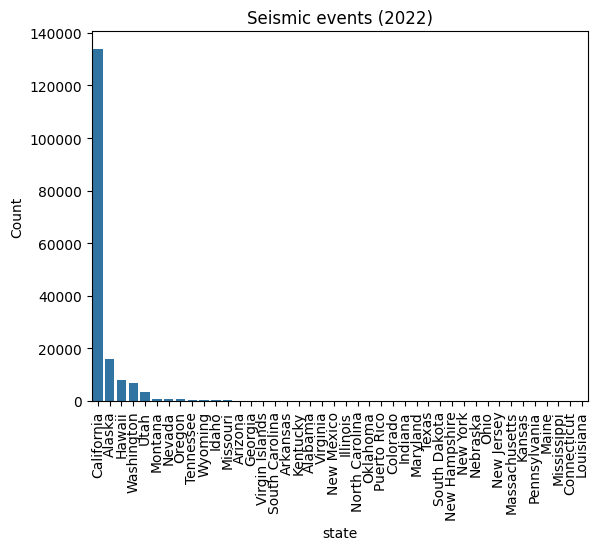

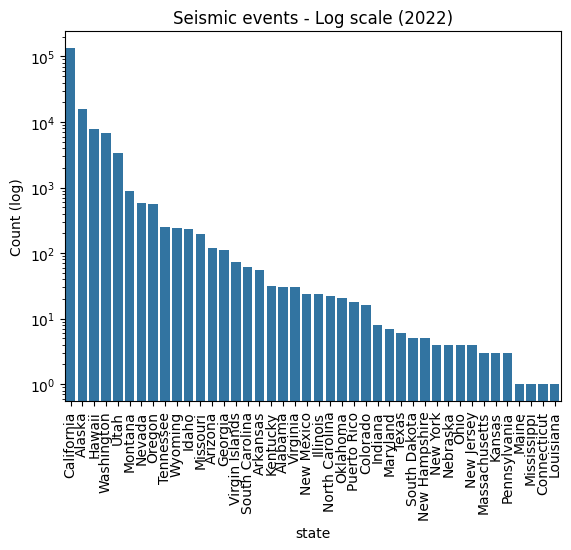

In [ ]:
sns.countplot(x = 'state', data = US_df, order = US_df['state'].value_counts(ascending = False).index)
plt.xlabel('state')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Seismic events (2022)')
plt.show()

sns.countplot(x = 'state', data = US_df, order = US_df['state'].value_counts(ascending = False).index)
plt.xlabel('state')
plt.xticks(rotation = 90)
plt.title('Seismic events - Log scale (2022)')
plt.yscale('log')
plt.ylabel('Count (log)')
plt.show()

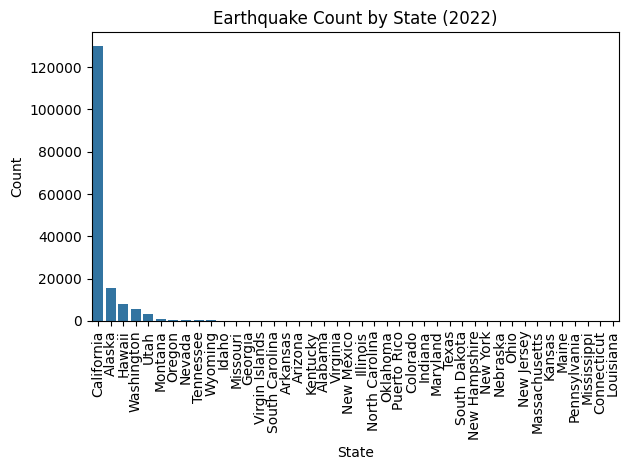

In [ ]:
# Filter only earthquake entries from the 'data_type' column
earthquakes = US_df[US_df['data_type'] == 'earthquake']

# Plot the count of earthquakes by state
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    x='state',
    data=earthquakes,
    order=earthquakes['state'].value_counts(ascending=False).index
)
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Earthquake Count by State (2022)')
plt.tight_layout()
plt.show()


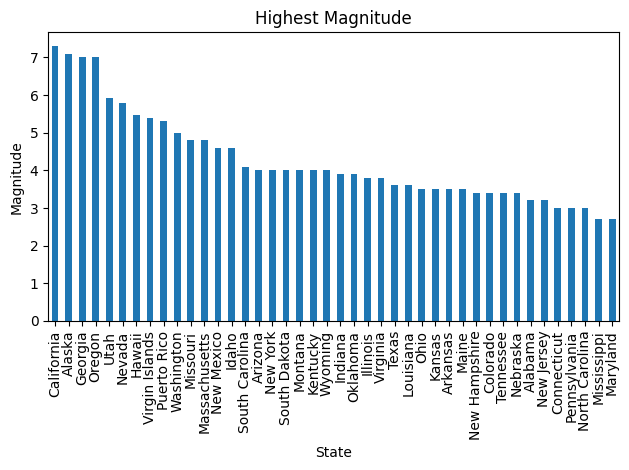

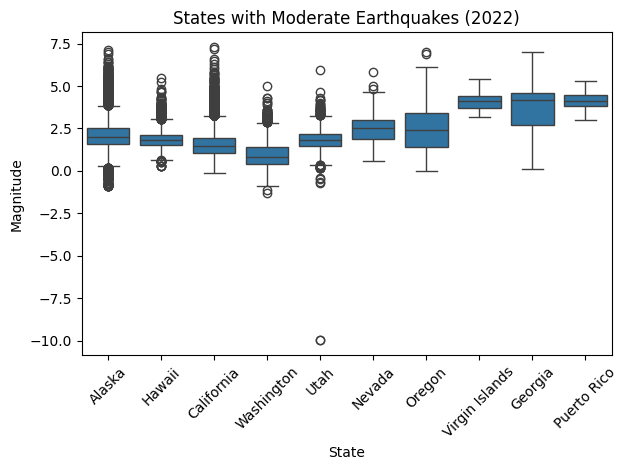

In [ ]:
# Bar plot of highest magnitudes by state
US_df.groupby('state')['magnitudo'].max().sort_values(ascending=False).plot(
    kind='bar', xlabel='State', ylabel='Magnitude', title='Highest Magnitude'
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create DataFrame with max magnitude per state
max_mags = pd.DataFrame(earthquakes.groupby('state')['magnitudo'].max()).reset_index()

# Filter for states with moderate or stronger earthquakes (magnitude ≥ 5.0)
mod_quake_states = max_mags[max_mags['magnitudo'] >= 5.0]

# Subset the original earthquake records for those states
earthquakes_to_analyze = earthquakes[earthquakes['state'].isin(mod_quake_states['state'])]

# Boxplot of magnitudes in states with significant earthquakes
sns.boxplot(x='state', y='magnitudo', data=earthquakes_to_analyze)
plt.xlabel('State')
plt.ylabel('Magnitude')
plt.title('States with Moderate Earthquakes (2022)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


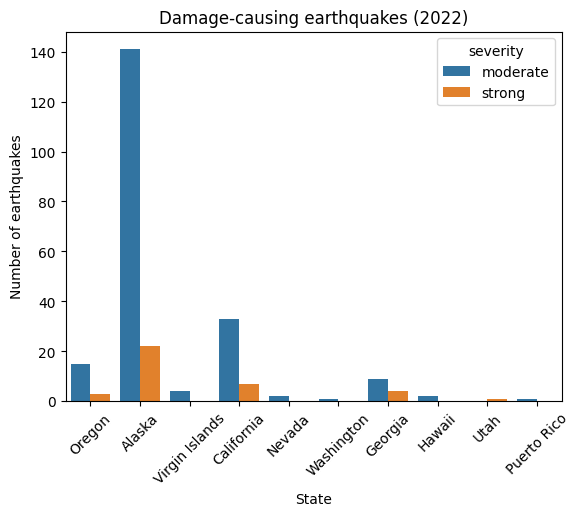

In [ ]:
moderate_and_strong = earthquakes_to_analyze[earthquakes_to_analyze['severity'].isin(['moderate', 'strong'])]
'''Subsets our dataframe of relevant  earthquakes for those that are considered moderate or strong'''
sns.countplot(x = 'state', data = moderate_and_strong, hue = 'severity').set(xlabel = 'State', ylabel = 'Number of earthquakes')
plt.title('Damage-causing earthquakes (2022)')
plt.xticks(rotation = 45)
plt.show()